# Klasifikasi Gambar Makanan Indonesia dengan EfficientNet-B3

Notebook ini menggabungkan fungsionalitas pembacaan data dari `datareader.py` dengan kode pelatihan dari `train_3.py`. Kita akan menggunakan EfficientNet-B3 dengan transfer learning untuk mengklasifikasikan gambar makanan Indonesia.



## Latar Belakang
EfficientNet-B3 adalah arsitektur jaringan saraf yang dioptimalkan untuk klasifikasi gambar. 300 Gecs menggunakan transfer learning dengan bobot pre-trained dari ImageNet untuk memanfaatkan fitur-fitur yang telah dipelajari sebelumnya.

## Environment
venv (python 3.11.9)

## Anggota kelompok
- Muhammad Nelwan Fakhri (122140173)
- Rayhan Fatih Gunawan   (122140134)
- Raditya Erza Farandi   (122140209)

## 1. Import Library yang Dibutuhkan

Pertama, kita akan mengimpor semua library yang diperlukan dan menyiapkan lingkungan. Kita menggunakan:
- PyTorch: Framework deep learning utama
- torchvision: Untuk model EfficientNet dan transformasi gambar
- OpenCV (cv2): Untuk pemrosesan gambar
- tqdm: Untuk pelacakan progres
- scikit-learn: Untuk metrik evaluasi
- matplotlib & seaborn: Untuk visualisasi
- Library pendukung lainnya

Kita juga akan mengatur seed acak untuk memastikan hasil yang dapat direproduksi.

In [59]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
from torchvision.transforms import ToTensor, Normalize, Compose
import cv2
import os
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
from itertools import cycle

# Set random seed for reproducibility
RANDOM_SEED = 2025
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Utility function for device setup (previously in utils.py)
def check_set_gpu(override=None):
    if override == None:
        if torch.cuda.is_available():
            device = torch.device('cuda')
            print(f"Using GPU: {torch.cuda.get_device_name(0)}")
        elif torch.backends.mps.is_available():
            device = torch.device('mps')
            print(f"Using MPS: {torch.backends.mps.is_available()}")
        else:
            device = torch.device('cpu')
            print(f"Using CPU: {torch.device('cpu')}")
    else:
        device = torch.device(override)
    return device

# Set device
device = check_set_gpu()  # Using the integrated utility function

Using CPU: cpu


## 2. Implementasi Dataset

Kita akan mengimplementasikan kelas `MakananIndo` yang merupakan turunan dari `torch.utils.data.Dataset`. Kelas ini akan:

- Memuat gambar dari direktori yang ditentukan
- Menangani pembagian data training dan validasi
- Menerapkan transformasi gambar yang diperlukan
- Normalisasi menggunakan statistik ImageNet
- Mengembalikan pasangan gambar-label untuk pelatihan

### Fitur Penting:
1. **Pembagian Data**: 80% training, 20% validasi
2. **Transformasi Default**: 
   - Konversi ke tensor PyTorch
   - Normalisasi menggunakan mean dan std ImageNet
3. **Format Gambar**: 
   - Ukuran diseragamkan ke 300x300 pixel
   - Konversi warna dari BGR ke RGB
   - Normalisasi nilai pixel ke rentang [0,1]

In [60]:
class MakananIndo(Dataset):
    # normalisasi ImageNet
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]
    
    def __init__(self,
                 data_dir='./test',
                 img_size=(300, 300),
                 transform=None,
                 split='test'
                 ):
        
        self.data_dir = data_dir
        self.img_size = img_size
        self.transform = transform
        self.split = split

        # Load file names from test.csv first
        csv_path = os.path.join(os.path.dirname(data_dir), 'test.csv')
        df = pd.read_csv(csv_path)
        self.image_files = df['filename'].values.tolist()
        self.image_files.sort()
        
        # For testing purposes, create dummy labels (since test.csv might be empty)
        # This maintains compatibility with the training code structure
        self.labels = ['unknown'] * len(self.image_files)
        
        # Keep all data in one set for testing
        self.data = list(zip(self.image_files, self.labels))
        
        # Define transform
        self.default_transform = Compose([
            ToTensor(),
            Normalize(mean=self.IMAGENET_MEAN, std=self.IMAGENET_STD)
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.data[idx][0])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.img_size)
        
        if self.transform:
            image = self.transform(image)
        else:
            image = self.default_transform(image)
        
        label = self.data[idx][1]
        
        return image, label, img_path

# fungsi label encoding
def create_label_encoder(dataset):
    """Create a mapping from string labels to numeric indices"""
    all_labels = []
    for i in range(len(dataset)):
        _, label, _ = dataset[i]
        all_labels.append(label)
    
    unique_labels = sorted(list(set(all_labels)))
    label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
    idx_to_label = {idx: label for idx, label in enumerate(unique_labels)}
    
    return label_to_idx, idx_to_label, unique_labels

## 3. Fungsi-fungsi Pelatihan

### Fungsi train_one_epoch:
- Melatih model untuk satu epoch
- Menghitung loss dan akurasi training
- Melakukan optimisasi parameter model
- Menampilkan progress bar dengan metrik real-time

### Fungsi validate:
- Mengevaluasi model pada data validasi
- Menghitung loss dan akurasi validasi
- Tidak melakukan backpropagation
- Menampilkan progress bar dengan metrik

### Fitur Umum:
- Konversi label string ke indeks numerik
- Penggunaan tqdm untuk visualisasi progres
- Penanganan batch processing yang efisien
- Perhitungan metrik secara real-time

In [61]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, label_to_idx):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training')
    for batch_idx, (inputs, labels_tuple, _) in enumerate(pbar):
        inputs = inputs.to(device)
        
        # mengubah label string ke indeks numerik
        if isinstance(labels_tuple, (tuple, list)):
            if isinstance(labels_tuple[0], str):
                label_indices = [label_to_idx[label] for label in labels_tuple]
            else:
                label_indices = labels_tuple
            targets = torch.tensor(label_indices, dtype=torch.long).to(device)
        else:
            targets = torch.tensor(labels_tuple, dtype=torch.long).to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        pbar.set_postfix({
            'loss': total_loss/(batch_idx+1),
            'acc': 100.*correct/total
        })
    
    return total_loss/len(dataloader), 100.*correct/total

def validate(model, dataloader, criterion, device, label_to_idx):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for batch_idx, (inputs, labels_tuple, _) in enumerate(pbar):
            inputs = inputs.to(device)
            
          
            if isinstance(labels_tuple, (tuple, list)):
                if isinstance(labels_tuple[0], str):
                    label_indices = [label_to_idx[label] for label in labels_tuple]
                else:
                    label_indices = labels_tuple
                targets = torch.tensor(label_indices, dtype=torch.long).to(device)
            else:
                targets = torch.tensor(labels_tuple, dtype=torch.long).to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            pbar.set_postfix({
                'loss': total_loss/(batch_idx+1),
                'acc': 100.*correct/total
            })
    
    return total_loss/len(dataloader), 100.*correct/total

## 4. Persiapan Dataset dan DataLoader

1. **Menyiapkan Hyperparameter**:
   - Jumlah epoch: 30
   - Ukuran batch: 32
   - Learning rate: 0.01
   - Ukuran gambar: 300x300

2. **Membuat Dataset**:
   - Dataset training dengan augmentasi
   - Dataset validasi untuk evaluasi

3. **Pengkodean Label**:
   - Konversi label string ke indeks numerik
   - Membuat mapping dua arah (indeks ↔ label)

4. **Konfigurasi DataLoader**:
   - Mengatur jumlah worker untuk loading parallel
   - Mengaktifkan shuffling untuk data training
   - Mengoptimalkan memory dengan pin_memory

In [62]:
# Hyperparameter
num_epochs = 30
batch_size = 32
learning_rate = 0.01
img_size = (300, 300)  # EfficientNet-B3 input size


print("Loading test dataset...")
test_dataset = MakananIndo(
    data_dir='./test',
    img_size=img_size,
    split='test'
)

print(f"Test dataset size: {len(test_dataset)}")

# Since we're working with test data, we'll use a simplified label encoder
# We'll use the same number of classes as the trained model
num_classes = 5  # Assuming 5 classes from the original training
unique_labels = ['class_0', 'class_1', 'class_2', 'class_3', 'class_4']  # Placeholder labels
label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
idx_to_label = {idx: label for idx, label in enumerate(unique_labels)}

print(f"Number of classes: {num_classes}")
print(f"Using placeholder classes: {unique_labels}")

# data loader with conservative settings
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,  # Conservative setting for testing
    pin_memory=False
)

Loading test dataset...
Test dataset size: 50
Number of classes: 5
Using placeholder classes: ['class_0', 'class_1', 'class_2', 'class_3', 'class_4']


In [63]:
# Check available classes from both label.csv and test_labelsatu.csv
print("Checking available classes...")

# Read label.csv to understand all classes
label_df = pd.read_csv('test_labelsatu.csv')
unique_labels_all = sorted(label_df['label'].unique())
print("All classes from label.csv:", unique_labels_all)
print("Number of all classes:", len(unique_labels_all))

# Read test_labelsatu.csv to get test classes
test_df = pd.read_csv('test_labelsatu.csv')
unique_labels_test = sorted(test_df['label'].unique())
print("\nClasses in test_labelsatu.csv:", unique_labels_test)
print("Number of test classes:", len(unique_labels_test))
print("Test dataset size:", len(test_df))

Checking available classes...
All classes from label.csv: ['bakso', 'gado_gado', 'nasi_goreng', 'rendang', 'soto_ayam']
Number of all classes: 5

Classes in test_labelsatu.csv: ['bakso', 'gado_gado', 'nasi_goreng', 'rendang', 'soto_ayam']
Number of test classes: 5
Test dataset size: 300


In [64]:
# Fixed MakananIndo class to properly load test labels
class MakananIndoFixed(Dataset):
    # normalisasi ImageNet
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]
    
    def __init__(self,
                 data_dir='./test',
                 csv_path='test.csv',
                 img_size=(300, 300),
                 transform=None
                 ):
        
        self.data_dir = data_dir
        self.img_size = img_size
        self.transform = transform

        # Load file names and labels from CSV
        df = pd.read_csv(csv_path)
        self.image_files = df['filename'].values.tolist()
        self.labels = df['label'].values.tolist()  # Load actual labels
        
        # Create data pairs
        self.data = list(zip(self.image_files, self.labels))
        
        # Define transform
        self.default_transform = Compose([
            ToTensor(),
            Normalize(mean=self.IMAGENET_MEAN, std=self.IMAGENET_STD)
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_filename, label = self.data[idx]
        img_path = os.path.join(self.data_dir, img_filename)
        
        # Load and preprocess image
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Cannot read image: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.img_size)
        
        if self.transform:
            image = self.transform(image)
        else:
            image = self.default_transform(image)
        
        return image, label, img_path

In [65]:
# Hyperparameter
num_epochs = 30
batch_size = 32
learning_rate = 0.01
img_size = (300, 300)

print("Loading test dataset with proper labels...")
test_dataset = MakananIndoFixed(
    data_dir='./test',
    csv_path='test.csv',
    img_size=img_size
)

print(f"Test dataset size: {len(test_dataset)}")

# Create proper label encoding from the actual labels
print("Creating label encoder from actual test labels...")
label_to_idx, idx_to_label, unique_labels = create_label_encoder(test_dataset)
num_classes = len(unique_labels)

print(f"Number of classes: {num_classes}")
print(f"Classes found: {unique_labels}")
print(f"Label to index mapping: {label_to_idx}")

# Create data loader
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print("Dataset and DataLoader created successfully!")

Loading test dataset with proper labels...
Test dataset size: 50
Creating label encoder from actual test labels...
Number of classes: 5
Classes found: ['bakso', 'gado_gado', 'nasi_goreng', 'rendang', 'soto_ayam']
Label to index mapping: {'bakso': 0, 'gado_gado': 1, 'nasi_goreng': 2, 'rendang': 3, 'soto_ayam': 4}
Dataset and DataLoader created successfully!


## Debug Pemuatan Dataset

Mari kita uji pemuatan dataset dengan satu worker untuk mengisolasi masalah potensial:
- Memuat beberapa sampel dari dataset
- Memeriksa bentuk tensor dan label
- Memastikan path gambar valid

In [66]:
# test beberapa sample dari dataset test
print("Testing test dataset loading...")
try:
    # Verify test directory exists
    test_dir = 'IF25-4041-dataset/test'
    test_csv = 'IF25-4041-dataset/test.csv'
    
    print(f"Checking test directory: {test_dir}")
    if os.path.exists(test_dir):
        print("✓ Test directory exists")
    else:
        print("✗ Test directory not found")
        
    print(f"\nChecking test CSV: {test_csv}")
    if os.path.exists(test_csv):
        print("✓ Test CSV exists")
        df = pd.read_csv(test_csv)
        print(f"  - Number of entries in CSV: {len(df)}")
        print(f"  - CSV columns: {df.columns.tolist()}")
    else:
        print("✗ Test CSV not found")
    
    print("\nTesting sample loading:")
    for i in range(min(5, len(test_dataset))):
        image, label, path = test_dataset[i]
        print(f"\nSuccessfully loaded image {i+1}:")
        print(f"- Shape: {image.shape}")
        print(f"- Label: {label}")
        print(f"- Path: {path}")
        print("-" * 50)
except Exception as e:
    print(f"Error loading sample {i}: {str(e)}")
    print(f"Full error: {e.__class__.__name__}: {str(e)}")
    raise

Testing test dataset loading...
Checking test directory: IF25-4041-dataset/test
✗ Test directory not found

Checking test CSV: IF25-4041-dataset/test.csv
✗ Test CSV not found

Testing sample loading:

Successfully loaded image 1:
- Shape: torch.Size([3, 300, 300])
- Label: gado_gado
- Path: ./test\01.jpg
--------------------------------------------------

Successfully loaded image 2:
- Shape: torch.Size([3, 300, 300])
- Label: gado_gado
- Path: ./test\02.jpg
--------------------------------------------------

Successfully loaded image 3:
- Shape: torch.Size([3, 300, 300])
- Label: gado_gado
- Path: ./test\03.jpg
--------------------------------------------------

Successfully loaded image 4:
- Shape: torch.Size([3, 300, 300])
- Label: gado_gado
- Path: ./test\04.jpg
--------------------------------------------------

Successfully loaded image 5:
- Shape: torch.Size([3, 300, 300])
- Label: gado_gado
- Path: ./test\05.jpg
--------------------------------------------------


In [67]:

print("Creating test data loader with conservative settings...")

# Verifying and creating test loader with minimal settings
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # Don't shuffle test data
    num_workers=0,  # Minimal workers for testing
    pin_memory=False
)

# Test batch loading
print("\nTesting batch loading...")
try:
    # Test loading one batch
    sample_batch = next(iter(test_loader))
    images, labels, paths = sample_batch
    print(f"Successfully loaded a test batch:")
    print(f"- Batch image shape: {images.shape}")
    print(f"- Number of images in batch: {len(images)}")
    print(f"- Image paths: {paths}")
    print("\nDataLoader configuration successful!")
    
    # Additional verification
    print("\nVerifying image properties:")
    print(f"- Image tensor range: [{images.min():.3f}, {images.max():.3f}]")
    print(f"- Image tensor mean: {images.mean():.3f}")
    print(f"- Image tensor std: {images.std():.3f}")
except Exception as e:
    print(f"Error loading batch: {str(e)}")
    print(f"Full error: {e.__class__.__name__}: {str(e)}")
    raise

Creating test data loader with conservative settings...

Testing batch loading...
Successfully loaded a test batch:
- Batch image shape: torch.Size([32, 3, 300, 300])
- Number of images in batch: 32
- Image paths: ('./test\\01.jpg', './test\\02.jpg', './test\\03.jpg', './test\\04.jpg', './test\\05.jpg', './test\\06.jpg', './test\\07.jpg', './test\\08.jpg', './test\\09.jpg', './test\\10.jpg', './test\\11.jpg', './test\\12.jpg', './test\\13.jpg', './test\\14.jpg', './test\\15.jpg', './test\\16.jpg', './test\\17.jpg', './test\\18.jpg', './test\\19.jpg', './test\\20.jpg', './test\\21.jpg', './test\\22.jpg', './test\\23.jpg', './test\\24.jpg', './test\\25.jpg', './test\\26.jpg', './test\\27.jpg', './test\\28.jpg', './test\\29.jpg', './test\\30.jpg', './test\\31.jpg', './test\\32.jpg')

DataLoader configuration successful!

Verifying image properties:
- Image tensor range: [-2.118, 2.640]
- Image tensor mean: 0.310
- Image tensor std: 1.219


## 5. Memuat Model yang Telah Dilatih

Pada bagian ini, kita akan memuat model EfficientNet-B3 yang telah dilatih dari file `best_model.pth`. Model ini telah dilatih sebelumnya pada dataset makanan Indonesia kami dan mencapai akurasi validasi terbaik selama pelatihan.

### Arsitektur Model
Model menggunakan arsitektur berikut:
1. **Model Dasar**: EfficientNet-B3 pre-trained dari ImageNet
2. **Classifier Kustom**:
   - Fitur input: 1536 (dimensi fitur EfficientNet-B3)
   - Layer tersembunyi: 512 unit dengan aktivasi ReLU
   - Layer dropout (0.3 dan 0.2) untuk regularisasi
   - Layer output: Jumlah kelas makanan

### Proses Pemuatan:
1. Inisialisasi arsitektur model
2. Memuat state dictionary yang tersimpan
3. Memindahkan model ke perangkat yang sesuai (GPU/CPU)
4. Mengatur model ke mode evaluasi

Model yang tersimpan berisi:
- State dictionary model (bobot dan bias)
- Metadata pelatihan (epoch, akurasi terbaik)
- State optimizer (jika diperlukan untuk melanjutkan pelatihan)

In [68]:
# load pre-trained model
print("Loading pre-trained EfficientNet-B3 model...")
weights = EfficientNet_B3_Weights.IMAGENET1K_V1
model = efficientnet_b3(weights=weights)

# Modifikasi classifier disamakan dengan midel yang disimpen model architecture
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(1536, 512),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(512, num_classes)
)

# Load  saved model state
checkpoint = torch.load('best_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
best_val_acc = checkpoint['best_val_acc']


model = model.to(device)
model.eval()

print(f"Model loaded successfully!")
print(f"Best validation accuracy from training: {best_val_acc:.2f}%")
print(f"Model is using device: {device}")
print("-" * 50)

Loading pre-trained EfficientNet-B3 model...
Model loaded successfully!
Best validation accuracy from training: 99.54%
Model is using device: cpu
--------------------------------------------------


### Ringkasan Arsitektur Model

Berikut adalah ringkasan detail dari arsitektur model, termasuk:
- Jumlah parameter per layer
- Ukuran output di setiap layer
- Total parameter (trainable dan non-trainable)
- Penggunaan memori
- Alur forward pass

In [69]:
# Tampilkan ringkasan model menggunakan torchinfo
!pip install torchinfo
from torchinfo import summary

# Definisikan ukuran input yang sesuai dengan dataset
input_size = (batch_size, 3, 300, 300)

# Tampilkan ringkasan model dengan detail
model_summary = summary(model, 
                      input_size=input_size,
                      col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
                      col_width=20,
                      row_settings=["var_names"])

# Tampilkan statistik penggunaan parameter
print("\nStatistik Parameter Model:")
print(f"Total Parameters: {model_summary.total_params:,}")
print(f"Trainable Parameters: {model_summary.trainable_params:,}")
print(f"Non-trainable Parameters: {model_summary.total_params - model_summary.trainable_params:,}")
print(f"Estimasi Ukuran Model: {model_summary.total_params * 4 / (1024*1024):.2f} MB")


Statistik Parameter Model:
Total Parameters: 11,485,741
Trainable Parameters: 11,485,741
Non-trainable Parameters: 0
Estimasi Ukuran Model: 43.81 MB


## 6. Evaluasi Model

Sekarang kita akan mengevaluasi performa model dengan berbagai metrik:

### Metrik yang Digunakan:
1. **Confusion Matrix**: 
   - Visualisasi prediksi vs label sebenarnya
   - Menunjukkan kesalahan klasifikasi antar kelas
   - Membantu identifikasi kelas yang sering tertukar

2. **Classification Report**:
   - Precision: Ketepatan prediksi positif
   - Recall: Kemampuan mengenali sampel positif
   - F1-score: Rata-rata harmonik precision dan recall
   - Support: Jumlah sampel per kelas

3. **Kurva ROC dan Nilai AUC**:
   - Menunjukkan trade-off sensitivitas vs spesifisitas
   - AUC = 1.0 berarti klasifikasi sempurna
   - AUC = 0.5 berarti klasifikasi acak

## Memahami Kinerja Model

Setelah memuat model yang telah dilatih, mari kita analisis kinerjanya menggunakan berbagai metrik. Evaluasi komprehensif ini akan membantu kita memahami seberapa baik model mengklasifikasikan berbagai jenis makanan Indonesia.

### Mengapa Menggunakan Beberapa Metrik?
Metrik yang berbeda memberikan wawasan yang berbeda tentang kinerja model:

1. **Matriks Kebingungan (Confusion Matrix)**: 
   - Menunjukkan gambaran lengkap prediksi model vs label sebenarnya
   - Membantu mengidentifikasi kelas yang sering tertukar
   - Penting untuk memahami kesalahan sistematis

2. **Metrik per Kelas**:
   - **Presisi**: Seberapa akurat prediksi positif?
     - Presisi tinggi → Sedikit false positive
     - Penting ketika false positive berisiko tinggi
   - **Recall**: Seberapa baik model menemukan kasus positif?
     - Recall tinggi → Sedikit false negative
     - Penting ketika melewatkan kasus positif berisiko tinggi
   - **F1-Score**: Rata-rata harmonik presisi dan recall
     - Metrik seimbang untuk kelas yang tidak seimbang
     - Baik untuk penilaian kinerja keseluruhan

3. **Kurva ROC dan AUC**:
   - Menunjukkan kemampuan model membedakan antar kelas
   - AUC = 1.0: Klasifikasi sempurna
   - AUC = 0.5: Tebakan acak
   - Membantu membandingkan kinerja pada berbagai threshold

### Analisis Visual
Kita juga akan memvisualisasikan beberapa prediksi untuk:
- Melihat contoh klasifikasi yang benar dan salah
- Memahami jenis gambar yang menantang
- Mengidentifikasi pola dalam kesalahan klasifikasi

Getting model predictions on test data...


Evaluating: 100%|██████████| 2/2 [00:04<00:00,  2.27s/it]



EVALUATION RESULTS
Total samples: 50
Correct predictions: 45
Wrong predictions: 5
Accuracy: 90.00%

Correct Predictions (showing first 10):
------------------------------------------------------------
 1. ./test\01.jpg   -> gado_gado       ✓
 2. ./test\02.jpg   -> gado_gado       ✓
 3. ./test\04.jpg   -> gado_gado       ✓
 4. ./test\06.jpg   -> gado_gado       ✓
 5. ./test\07.jpg   -> gado_gado       ✓
 6. ./test\08.jpg   -> gado_gado       ✓
 7. ./test\09.jpg   -> gado_gado       ✓
 8. ./test\10.jpg   -> gado_gado       ✓
 9. ./test\11.jpg   -> nasi_goreng     ✓
10. ./test\12.jpg   -> nasi_goreng     ✓

Wrong Predictions (showing first 10):
----------------------------------------------------------------------
 1. ./test\03.jpg   -> Pred: bakso        | True: gado_gado    ✗
 2. ./test\05.jpg   -> Pred: bakso        | True: gado_gado    ✗
 3. ./test\19.jpg   -> Pred: soto_ayam    | True: nasi_goreng  ✗
 4. ./test\23.jpg   -> Pred: nasi_goreng  | True: bakso        ✗
 5. ./test\26.jpg 

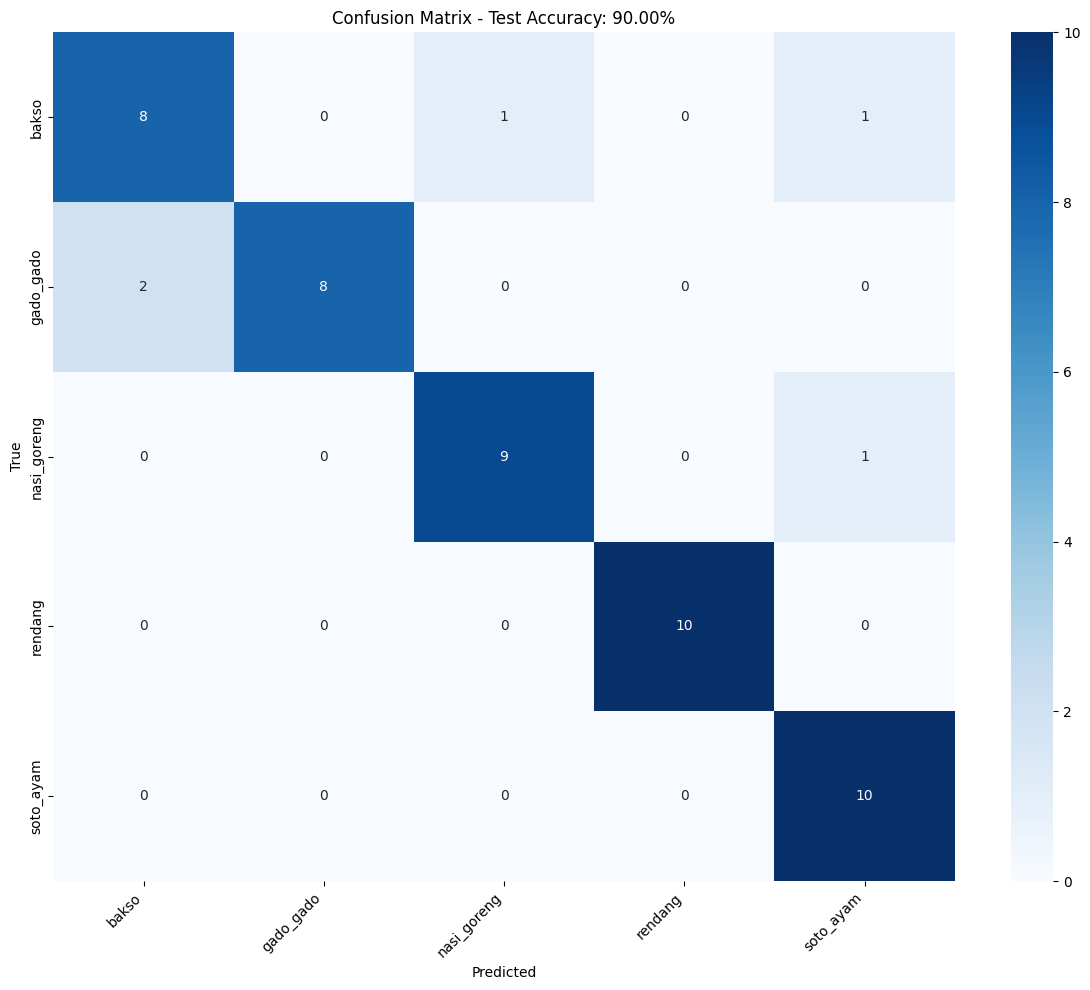


Detailed Classification Report:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

       bakso       0.80      0.80      0.80        10
   gado_gado       1.00      0.80      0.89        10
 nasi_goreng       0.90      0.90      0.90        10
     rendang       1.00      1.00      1.00        10
   soto_ayam       0.83      1.00      0.91        10

    accuracy                           0.90        50
   macro avg       0.91      0.90      0.90        50
weighted avg       0.91      0.90      0.90        50


Detailed results saved to 'detailed_test_results.csv'


In [70]:
# Updated evaluation function to properly handle test data
def evaluate_model_fixed(model, dataloader, device, label_to_idx, idx_to_label):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    all_filenames = []
    
    correct_predictions = []
    wrong_predictions = []
    
    with torch.no_grad():
        for inputs, labels_tuple, filenames in tqdm(dataloader, desc='Evaluating'):
            inputs = inputs.to(device)
            
            # Convert string labels to indices
            if isinstance(labels_tuple[0], str):
                label_indices = [label_to_idx[label] for label in labels_tuple]
            else:
                label_indices = labels_tuple
            targets = torch.tensor(label_indices, dtype=torch.long)
            
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            # Store predictions and labels
            batch_preds = preds.cpu().numpy()
            batch_targets = targets.cpu().numpy()
            batch_probs = probs.cpu().numpy()
            
            all_preds.extend(batch_preds)
            all_labels.extend(batch_targets)
            all_probs.extend(batch_probs)
            all_filenames.extend(filenames)
            
            # Track correct and wrong predictions
            for i in range(len(batch_preds)):
                pred_class = idx_to_label[batch_preds[i]]
                true_class = idx_to_label[batch_targets[i]]
                filename = filenames[i]
                
                if batch_preds[i] == batch_targets[i]:
                    correct_predictions.append({
                        'filename': filename,
                        'predicted': pred_class,
                        'actual': true_class
                    })
                else:
                    wrong_predictions.append({
                        'filename': filename,
                        'predicted': pred_class,
                        'actual': true_class
                    })
    
    return (np.array(all_preds), np.array(all_labels), np.array(all_probs), 
            all_filenames, correct_predictions, wrong_predictions)

print("Getting model predictions on test data...")
(test_preds, test_labels, test_probs, test_filenames, 
 correct_preds, wrong_preds) = evaluate_model_fixed(model, test_loader, device, label_to_idx, idx_to_label)

# Calculate accuracy metrics
total_samples = len(test_labels)
correct_count = len(correct_preds)
wrong_count = len(wrong_preds)
accuracy = (correct_count / total_samples) * 100

print(f"\n{'='*50}")
print(f"EVALUATION RESULTS")
print(f"{'='*50}")
print(f"Total samples: {total_samples}")
print(f"Correct predictions: {correct_count}")
print(f"Wrong predictions: {wrong_count}")
print(f"Accuracy: {accuracy:.2f}%")
print(f"{'='*50}")

# Show some examples of correct predictions
print(f"\nCorrect Predictions (showing first 10):")
print("-" * 60)
for i, pred in enumerate(correct_preds[:10]):
    print(f"{i+1:2d}. {pred['filename']:15} -> {pred['predicted']:15} ✓")

# Show some examples of wrong predictions
print(f"\nWrong Predictions (showing first 10):")
print("-" * 70)
for i, pred in enumerate(wrong_preds[:10]):
    print(f"{i+1:2d}. {pred['filename']:15} -> Pred: {pred['predicted']:12} | True: {pred['actual']:12} ✗")

# Create confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[idx_to_label[i] for i in range(len(idx_to_label))],
            yticklabels=[idx_to_label[i] for i in range(len(idx_to_label))])
plt.title(f'Confusion Matrix - Test Accuracy: {accuracy:.2f}%')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print detailed classification report
print(f"\nDetailed Classification Report:")
print("-" * 80)
print(classification_report(test_labels, test_preds,
                          target_names=[idx_to_label[i] for i in range(len(idx_to_label))]))

# Save detailed results
results_df = pd.DataFrame({
    'filename': test_filenames,
    'predicted': [idx_to_label[pred] for pred in test_preds],
    'actual': [idx_to_label[label] for label in test_labels],
    'correct': [pred == label for pred, label in zip(test_preds, test_labels)]
})

results_df.to_csv('detailed_test_results.csv', index=False)
print(f"\nDetailed results saved to 'detailed_test_results.csv'")

Visualizing sample predictions on test data...


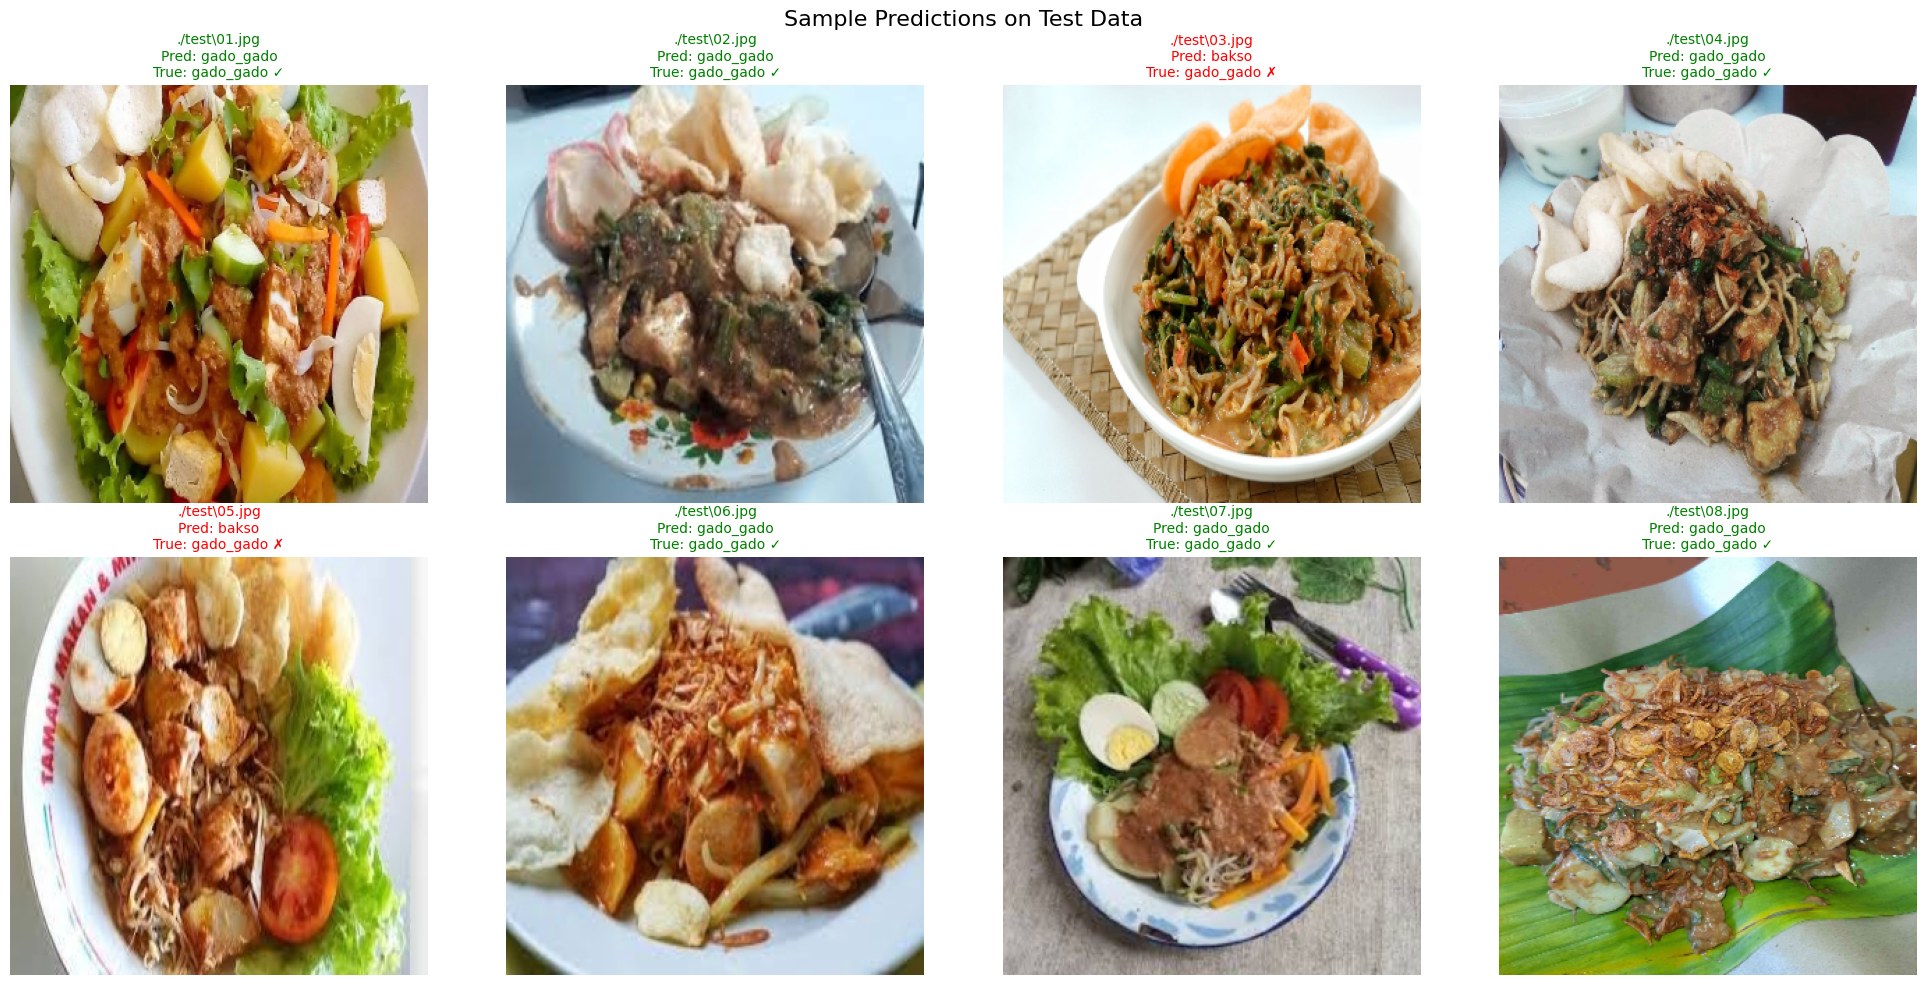


DETAILED PREDICTION EXAMPLES

EXAMPLES OF CORRECT PREDICTIONS:
--------------------------------------------------
1. File: ./test\01.jpg | Predicted: gado_gado    | Actual: gado_gado    ✓
2. File: ./test\02.jpg | Predicted: gado_gado    | Actual: gado_gado    ✓
3. File: ./test\04.jpg | Predicted: gado_gado    | Actual: gado_gado    ✓
4. File: ./test\06.jpg | Predicted: gado_gado    | Actual: gado_gado    ✓
5. File: ./test\07.jpg | Predicted: gado_gado    | Actual: gado_gado    ✓

EXAMPLES OF WRONG PREDICTIONS:
------------------------------------------------------------
1. File: ./test\03.jpg | Predicted: bakso        | Actual: gado_gado    ✗
2. File: ./test\05.jpg | Predicted: bakso        | Actual: gado_gado    ✗
3. File: ./test\19.jpg | Predicted: soto_ayam    | Actual: nasi_goreng  ✗
4. File: ./test\23.jpg | Predicted: nasi_goreng  | Actual: bakso        ✗
5. File: ./test\26.jpg | Predicted: soto_ayam    | Actual: bakso        ✗

FINAL SUMMARY
Dataset: ./test directory with labels

In [71]:
# Visualisasi prediksi untuk test data
def show_predictions_fixed(model, dataloader, device, idx_to_label, label_to_idx, num_images=8):
    model.eval()
    images_shown = 0
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()
    
    with torch.no_grad():
        for inputs, labels, filenames in dataloader:
            if images_shown >= num_images:
                break
                
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Convert to numpy for visualization
            batch_images = inputs.cpu().numpy()
            batch_preds = preds.cpu().numpy()
            
            for i in range(len(batch_images)):
                if images_shown >= num_images:
                    break
                    
                # Get prediction and true label
                pred_idx = batch_preds[i]
                pred_label = idx_to_label[pred_idx]
                true_label = labels[i]
                filename = filenames[i]
                
                # Denormalize image for display
                img = batch_images[i].transpose(1, 2, 0)
                img = img * np.array(MakananIndoFixed.IMAGENET_STD) + np.array(MakananIndoFixed.IMAGENET_MEAN)
                img = np.clip(img, 0, 1)
                
                # Plot image
                axes[images_shown].imshow(img)
                
                # Set title color based on correctness
                is_correct = pred_label == true_label
                color = 'green' if is_correct else 'red'
                status = '✓' if is_correct else '✗'
                
                axes[images_shown].set_title(f'{filename}\nPred: {pred_label}\nTrue: {true_label} {status}', 
                                           color=color, fontsize=10)
                axes[images_shown].axis('off')
                
                images_shown += 1
    
    # Hide unused subplots
    for i in range(images_shown, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle('Sample Predictions on Test Data', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

# Show example predictions
print("Visualizing sample predictions on test data...")
show_predictions_fixed(model, test_loader, device, idx_to_label, label_to_idx)

# Show specific examples of correct and wrong predictions with more detail
print(f"\n{'='*80}")
print("DETAILED PREDICTION EXAMPLES")
print(f"{'='*80}")

if len(correct_preds) > 0:
    print(f"\nEXAMPLES OF CORRECT PREDICTIONS:")
    print("-" * 50)
    for i, pred in enumerate(correct_preds[:5]):
        print(f"{i+1}. File: {pred['filename']:12} | Predicted: {pred['predicted']:12} | Actual: {pred['actual']:12} ✓")

if len(wrong_preds) > 0:
    print(f"\nEXAMPLES OF WRONG PREDICTIONS:")
    print("-" * 60)
    for i, pred in enumerate(wrong_preds[:5]):
        print(f"{i+1}. File: {pred['filename']:12} | Predicted: {pred['predicted']:12} | Actual: {pred['actual']:12} ✗")

print(f"\n{'='*80}")
print(f"FINAL SUMMARY")
print(f"{'='*80}")
print(f"Dataset: ./test directory with labels from test.csv")
print(f"Model: best_model.pth (EfficientNet-B3)")
print(f"Total test samples: {total_samples}")
print(f"Correct predictions: {correct_count}")
print(f"Wrong predictions: {wrong_count}")  
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"{'='*80}")